In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

import sys
sys.path.insert(1, '../library')
sys.path.insert(2, '../python_library')

import pyram as pr

from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations

from scipy.spatial import distance
from scipy.optimize import minimize

%matplotlib inline

Welcome to pyram: your Raman analysis library!


# Charge example spectra

In [2]:
pr.charge_lib('short')

lib = pr.lib()
lib_names = list(lib.keys())
pr.cwd('example_data')
pr.set_alias()

Charging pure spectra library, needs around a minute ....
Done. Good work!
txt0  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt1  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt2  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt4  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt5  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt6  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt
txt8  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt11  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt


# Simultaneous bkg and spectra fit

## 1D search in the library

## Select the spectra

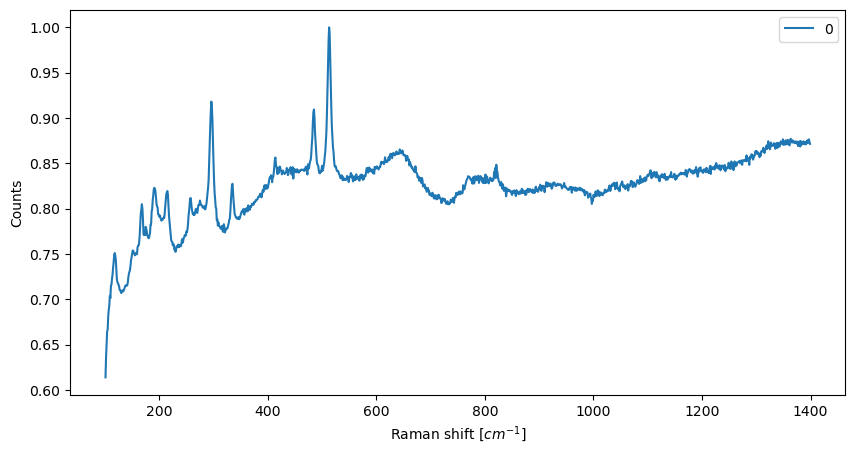

In [21]:
# take an unknown spectra with bkg

S=pr.type2spectra('txt10')
S = S[:,S[0]<1400]
pr.plot(S)

## Prepare resized library
The referance library must be resied according to the portion of spectrum we are working with.

In [ ]:
##########
# BKG
sigma = 70
p = 100
delta = sigma #(>> sigma)
method = 'gauss'

#FIT
shift = 5
##########

In [22]:
# create matrix LIB

LIB = np.zeros((len(lib_names), len(S[0])))

for i in range(len(lib_names)):
    P = np.copy(lib[lib_names[i]])

    # restringo P se troppo grande
    if P[0][0]<S[0][0] or P[0][-1]>S[0][-1]:
        P = P[:,P[0]>=S[0][0]]
        P = P[:,P[0]<=S[0][-1]]



    # generate PAD with zeros of P
    n_min = np.where(S[0]==P[0][0])
    n_max = np.where(S[0]==P[0][-1])
    
    P_pad = np.copy(S)
    P_pad[1][n_min[0][0]:n_max[0][0]+1] = P[1]
    P_pad[1][0:n_min[0][0]] *= 0 
    P_pad[1][n_max[0][0]:] *= 0

    LIB[i] = P_pad[1]/(np.linalg.norm(P_pad[1]))

## Matrice di bkg template functions

In [23]:
# generate array of bkg template functions

# gaussian function in numpy
def gauss(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# sinc function in numpy
def sinc(x, mu, sigma):
    return np.sinc((x-mu)/sigma)

mus = np.linspace(S[0,0]-delta, S[0,-1]+delta, p)

G = np.zeros((p,len(S[0])))

if method == 'gauss':
    for i in range(p):
        G[i] = gauss(S[0], mus[i], sigma)

if method == 'sinc':
    for i in range(p):
        G[i] = sinc(S[0], mus[i], sigma)

In [24]:
# RICAMPIONO VETTORI per aumentare velocità

LIB = LIB[:,::2]
G = G[:,::2]
S = S[:,::2]


,name,ID,match,res
0,Albite,2,0.979679,5.290649e+05
1,Orthoclase,59,0.657441,2.648497e+06
2,Microcline,22,0.820629,2.977158e+06
3,Chalcopyrite,27,0.799285,3.000002e+06
5,Nontronite,36,0.642195,3.551259e+06
6,Dwornikite,34,0.933810,3.650608e+06
7,Armalcolite,43,0.899066,3.846582e+06
8,Titanite,0,0.961352,3.858609e+06
9,Goethite,56,0.489329,3.893606e+06
10,Arsenopyrite,10,0.764611,3.935438e+06


Text(0, 0.5, 'Intensity [a.u.]')

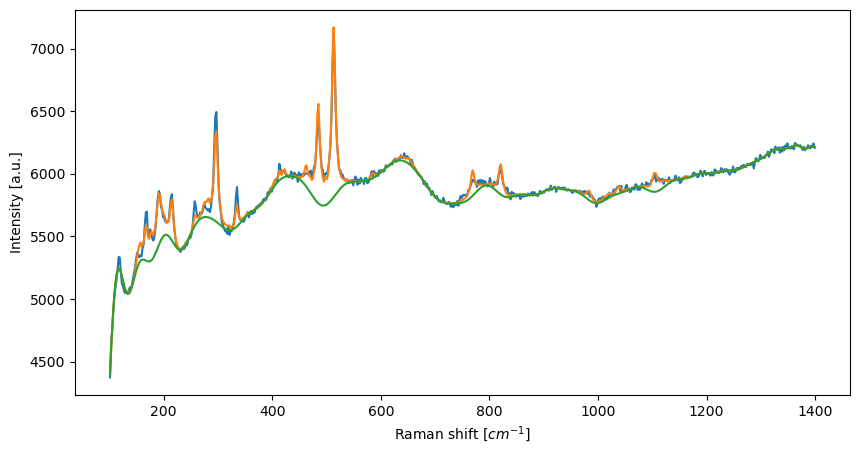

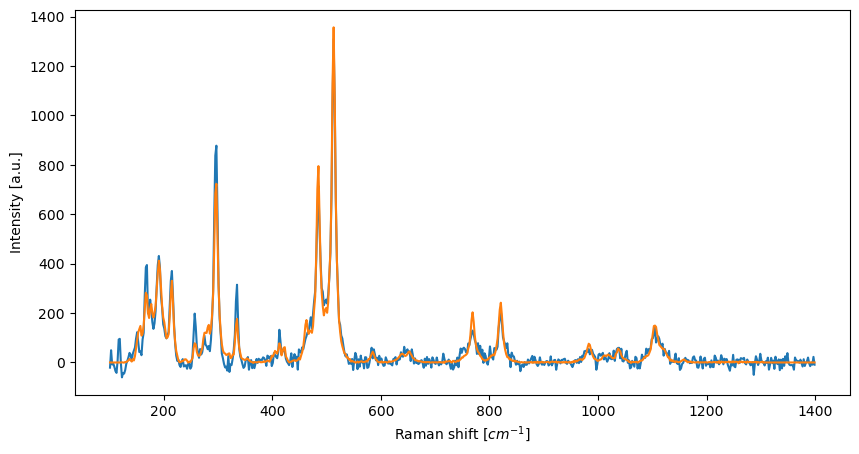

In [27]:
# FIT with shifts

# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))



shift_vec = np.arange(-shift,shift+1)
Ps = np.zeros((2*shift+1, len(S[0])))
out = []

for i in range(len(lib_names)):

    for s in shift_vec:

        P_shifted = np.roll(LIB[i],s)

        if s>0:
            P_shifted[:s] *= 0
        if s<0:
            P_shifted[s:] *= 0

        Ps[s] = P_shifted

    #### fit
    Y = np.append(Ps, G, axis=0)
    fit = scipy.linalg.lstsq(Y.transpose(), S[1], lapack_driver='gelsy')
    
    # salvo risultato
    bkg = (G.transpose() * fit[0][2*shift+1:]).sum(axis=1)
    I = fit[0][:2*shift+1]
    P = (Ps.transpose() * I).sum(axis=1)

    res = ((bkg+P-S[1])**2).sum()
    
    # riassumo info

    match = cosine_similarity(S[1]-bkg, P)

    # SALVO
    out.append([lib_names[i], i, match, res, P, bkg, I.sum()])
    
out = pd.DataFrame(out, columns=['name', 'ID', 'match', 'res', 'P', 'bkg','I']).sort_values(by='res', ascending=True).reset_index(drop=True)
out = out[out['I']>0]
display(out[['name','ID','match','res']].head(15))


# PLOTS

plt.figure(figsize=(10,5))
plt.plot(S[0], S[1], label='signal')
plt.plot(S[0], out.P[0]+out.bkg[0], label=out.name[0])
plt.plot(S[0], out.bkg[0], label='background')
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.figure(figsize=(10,5))
plt.plot(S[0], S[1]-out.bkg[0], label='signal')
plt.plot(S[0], out.P[0], label='fit')
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')